# Linear Algebra: Principal Component Analysis

This notebook generates visualizations for PCA, dimensionality reduction, and variance explained.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## PCA Implementation

In [3]:
def pca_from_svd(X):
    """PCA using SVD."""
    # Center the data
    X_centered = X - X.mean(axis=0)

    # SVD
    U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)

    # Principal components are rows of Vt (columns of V)
    components = Vt

    # Variance explained (eigenvalues = s^2 / (n-1))
    n = X.shape[0]
    variance = s**2 / (n - 1)

    return variance, components, X_centered

def transform(X, components, k):
    """Project data onto first k principal components."""
    X_centered = X - X.mean(axis=0)
    return X_centered @ components[:k].T

## PCA on 2D Data - Principal Components Visualization

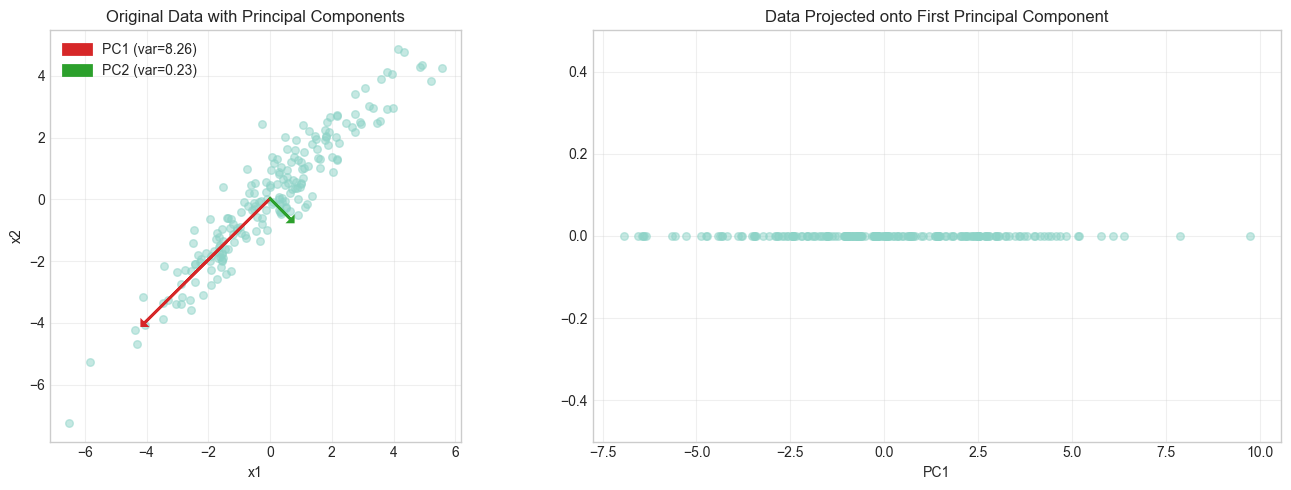

In [4]:
# Generate 2D data with correlation
np.random.seed(42)
theta = np.pi / 4
rotation = np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]])
X_2d = np.random.randn(200, 2) @ np.diag([3, 0.5]) @ rotation.T

# Perform PCA
variance, components, X_centered = pca_from_svd(X_2d)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original data with principal components
ax = axes[0]
ax.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5, s=30)
origin = X_2d.mean(axis=0)

# Plot principal components scaled by sqrt(variance)
colors = ['#d62728', '#2ca02c']
for i in range(2):
    scale = np.sqrt(variance[i]) * 2
    ax.arrow(origin[0], origin[1],
             components[i, 0] * scale, components[i, 1] * scale,
             head_width=0.2, head_length=0.1, fc=colors[i], ec=colors[i],
             linewidth=2, label=f'PC{i+1} (var={variance[i]:.2f})')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Original Data with Principal Components')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Projected data (1D)
X_projected = transform(X_2d, components, 1)
ax = axes[1]
ax.scatter(X_projected, np.zeros_like(X_projected), alpha=0.5, s=30)
ax.set_xlabel('PC1')
ax.set_title('Data Projected onto First Principal Component')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.savefig('../../static/img/post/linear-algebra/pca-2d-projection.png', dpi=150, bbox_inches='tight')
plt.show()

## Explained Variance and Scree Plot

Explained variance ratio:
  PC1: 92.46% (cumulative: 92.46%)
  PC2: 5.31% (cumulative: 97.77%)
  PC3: 1.71% (cumulative: 99.48%)
  PC4: 0.52% (cumulative: 100.00%)


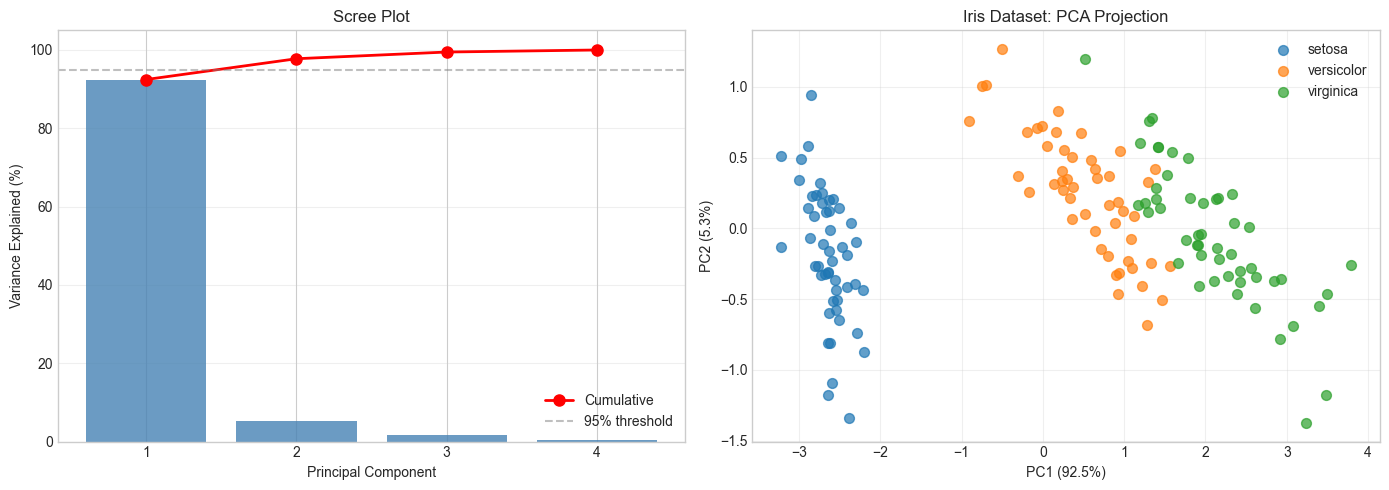

In [5]:
# Use Iris dataset
iris = load_iris()
X_iris = iris.data

# PCA
variance, components, X_centered = pca_from_svd(X_iris)
explained_ratio = variance / variance.sum()
cumulative_ratio = np.cumsum(explained_ratio)

print("Explained variance ratio:")
for i, (var, ratio, cum) in enumerate(zip(variance, explained_ratio, cumulative_ratio)):
    print(f"  PC{i+1}: {ratio*100:.2f}% (cumulative: {cum*100:.2f}%)")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, 5), explained_ratio * 100, color='steelblue', alpha=0.8)
axes[0].plot(range(1, 5), cumulative_ratio * 100, 'ro-', markersize=8, linewidth=2, label='Cumulative')
axes[0].axhline(y=95, color='gray', linestyle='--', alpha=0.5, label='95% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title('Scree Plot')
axes[0].set_xticks(range(1, 5))
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Project to 2D
X_pca = X_centered @ components[:2].T
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, target in enumerate(np.unique(iris.target)):
    mask = iris.target == target
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[i],
                    label=iris.target_names[target], alpha=0.7, s=50)

axes[1].set_xlabel(f'PC1 ({explained_ratio[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({explained_ratio[1]*100:.1f}%)')
axes[1].set_title('Iris Dataset: PCA Projection')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../static/img/post/linear-algebra/pca-iris.png', dpi=150, bbox_inches='tight')
plt.show()

## Reconstruction from PCA

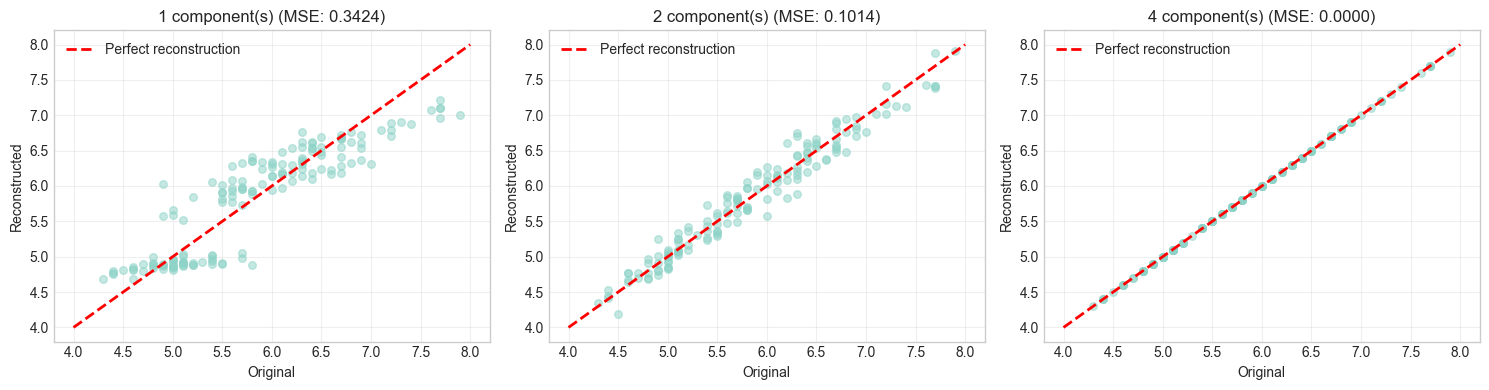

In [6]:
def inverse_transform(X_reduced, components, mean, n_components):
    """Reconstruct data from PCA representation."""
    return X_reduced @ components[:n_components] + mean

# Reconstruct iris data with different numbers of components
mean = X_iris.mean(axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
n_comps = [1, 2, 4]

for ax, n in zip(axes, n_comps):
    X_reduced = (X_iris - mean) @ components[:n].T
    X_reconstructed = inverse_transform(X_reduced, components, mean, n)
    error = np.mean(np.sum((X_iris - X_reconstructed)**2, axis=1))

    ax.scatter(X_iris[:, 0], X_reconstructed[:, 0], alpha=0.5, s=30)
    ax.plot([4, 8], [4, 8], 'r--', linewidth=2, label='Perfect reconstruction')
    ax.set_xlabel('Original')
    ax.set_ylabel('Reconstructed')
    ax.set_title(f'{n} component(s) (MSE: {error:.4f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../static/img/post/linear-algebra/pca-reconstruction.png', dpi=150, bbox_inches='tight')
plt.show()

## Whitening Comparison

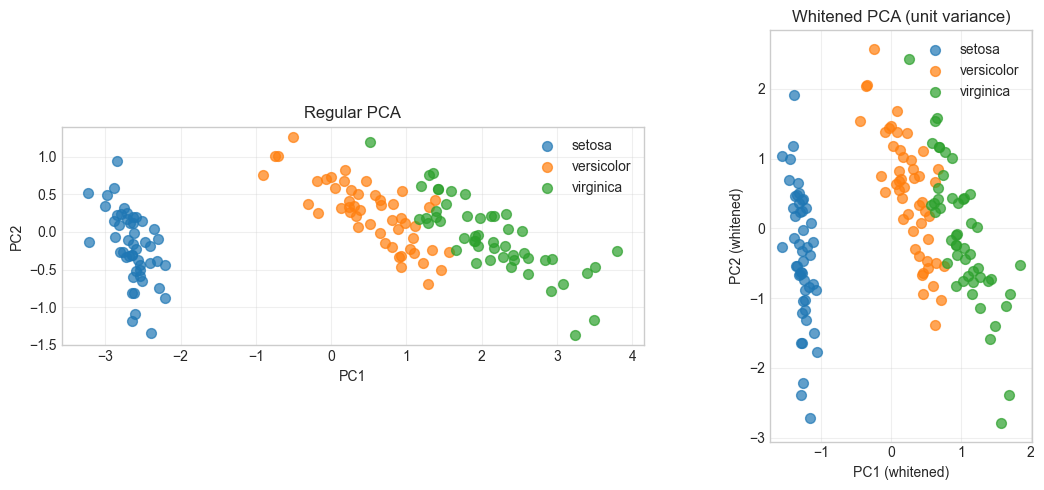

Regular PCA covariance:
[[ 4.22824171e+00 -8.10686343e-16]
 [-8.10686343e-16  2.42670748e-01]]

Whitened covariance (should be identity):
[[1.00000000e+00 5.96092899e-17]
 [5.96092899e-17 1.00000000e+00]]


In [7]:
def pca_whiten(X, n_components=None):
    """PCA with whitening."""
    X_centered = X - X.mean(axis=0)
    U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)

    if n_components is None:
        n_components = min(X.shape)

    # Whitened data: divide by singular values
    X_whitened = U[:, :n_components] * np.sqrt(X.shape[0] - 1)

    return X_whitened

# Compare regular PCA vs whitened
X_pca = (X_iris - X_iris.mean(axis=0)) @ components[:2].T
X_whitened = pca_whiten(X_iris, n_components=2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regular PCA
for i, target in enumerate(np.unique(iris.target)):
    mask = iris.target == target
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[i],
                    label=iris.target_names[target], alpha=0.7, s=50)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Regular PCA')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Whitened PCA
for i, target in enumerate(np.unique(iris.target)):
    mask = iris.target == target
    axes[1].scatter(X_whitened[mask, 0], X_whitened[mask, 1], c=colors[i],
                    label=iris.target_names[target], alpha=0.7, s=50)
axes[1].set_xlabel('PC1 (whitened)')
axes[1].set_ylabel('PC2 (whitened)')
axes[1].set_title('Whitened PCA (unit variance)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.savefig('../../static/img/post/linear-algebra/pca-whitening.png', dpi=150, bbox_inches='tight')
plt.show()

print("Regular PCA covariance:")
print(np.cov(X_pca.T))
print("\nWhitened covariance (should be identity):")
print(np.cov(X_whitened.T))